In [1]:
%matplotlib inline
%load_ext zipline

**注意**，使用`data.history`时，`price`会前向填充，但其他字段`("open", "high", "low", "close", "volume")`则不会。

In [2]:
%%zipline --start 2018-1-1 --end 2018-4-27

from zipline import get_calendar
from logbook import Logger
from zipline.api import (symbols, time_rules, schedule_function, date_rules,
                         attach_pipeline, pipeline_output,
                         order_target_percent, get_datetime, calendars)
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import DailyReturns, Returns
from zipline.pipeline.builtin import IsResumed, SuccessiveSuspensionDays

import datetime
import pandas as pd
import numpy as np

log = Logger('回测')
day = get_calendar('SZSH').day
MIN_DAYS = 30 # 最少连续停牌交易日数量

def make_pipeline():

    return Pipeline(
        columns={
            'pct': DailyReturns(),
            'days': SuccessiveSuspensionDays(include=True)
        },
        screen=IsResumed())


def initialize(context):
    # 保存复牌股票清单，主键为asset，值为复牌后的天数
    context.resumed_assets = {}
    context.output = None
    context.report = None
    my_pipe = make_pipeline()
    attach_pipeline(my_pipe, 'my_pipeline')
    # 每天收盘后，处理报告
    schedule_function(
        handle_report,
        date_rules.every_day(),
        time_rules.market_close(minutes=1),
        calendar=calendars.US_EQUITIES)


def handle_data(context, data):
    #print(context.resumed_assets)
    pass


def update_roc(context, data, num):
    """更新roc列数值"""
    # 找出复牌后num天的股票
    stocks = []
    for stock, days in context.resumed_assets.items():
        if days == num:
            stocks.append(stock)
    # 不存在符合条件的，返回即可
    if len(stocks) == 0:
        return
    # 要想获得完整数据，需要多加1个交易日
    history = data.history(
        stocks, fields="close", bar_count=num + 1, frequency="1d")
    # 取最后一行，转置为以股票作为index
    roc = history.pct_change(num).iloc[-1, :].T
    col_name = 'afer_{}_days'.format(num)
    context.report.loc[roc.index, col_name] = roc.values


def update_report(context, data, df):
    """更新复牌后交易天数,整理报告"""
    # 添加新增复牌股票到上下文字典
    cond = df['days'] >= MIN_DAYS
    gt_30_stocks = df[cond].index
    
    # 如不在字典中，添加并赋值天数为0
    for stock in gt_30_stocks:
        if stock not in context.resumed_assets.keys():
            context.resumed_assets[stock] = 0

    # 更新字典中股票复牌后成交天数
    for stock in context.resumed_assets.keys():
        days = context.resumed_assets[stock] + 1
        context.resumed_assets[stock] = days
    
    to_add = df.loc[gt_30_stocks]
    # 如原始数据非空, 增加2列
    if not to_add.empty:
        to_add['afer_5_days'] = np.nan
        to_add['afer_10_days'] = np.nan
        # 添加停牌分析报告
        if context.report is None:
            # 如空，则直接赋值
            context.report = to_add
        else:
            # 如已有数据，行合并
            # 防止重复，只能添加新增加的股票，已经存在的无需添加
            # 这样，如果股票复牌后再次停牌，则只会统计前次停牌的数据，忽略后续停牌
            old_stocks = context.report.index
            new_add_stocks = to_add.index.difference(old_stocks)
            context.report = pd.concat([context.report, to_add.loc[new_add_stocks]], verify_integrity=True)

    # 更新复牌5天股票收益率
    update_roc(context, data, 5)
    # 更新复牌10天股票收益率
    update_roc(context, data, 10)


def handle_report(context, data):
    """处理分析报告"""
    output = pipeline_output('my_pipeline')
    d = get_datetime('Asia/Shanghai')
    if output is not None:
        #log.info('日期:{},复牌家数:{}'.format(d.date(), output.shape[0]))
        output['begin_date'] = (d - day).date()
        update_report(context, data, output)
        # 重复保存，只需要最终结果
        context.report.to_pickle('report.pkl')

[2018-05-02 22:28:58.827958] INFO: zipline.finance.metrics.tracker: Simulated 76 trading days
first open: 2018-01-02 01:31:00+00:00
last close: 2018-04-27 07:00:00+00:00


,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2018-01-02 07:00:00+00:00,NaN,0.0,NaN,0.014028,NaN,NaN,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,1,[],0.0
2018-01-03 07:00:00+00:00,0.0,0.0,0.0,0.019980,0.091573,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,2,[],0.0
2018-01-04 07:00:00+00:00,0.0,0.0,0.0,0.024302,0.083268,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,3,[],0.0
2018-01-05 07:00:00+00:00,0.0,0.0,0.0,0.026767,0.081394,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,4,[],0.0
2018-01-08 07:00:00+00:00,0.0,0.0,0.0,0.032079,0.071249,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,5,[],0.0
2018-01-09 07:00:00+00:00,0.0,0.0,0.0,0.039308,0.063871,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,6,[],0.0
2018-01-10 07:00:00+00:00,0.0,0.0,0.0,0.043901,0.059569,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,7,[],0.0
2018-01-11 07:00:00+00:00,0.0,0.0,0.0,0.043349,0.066724,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,8,[],0.0
2018-01-12 07:00:00+00:00,0.0,0.0,0.0,0.048165,0.062527,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,9,[],0.0
2018-01-15 07:00:00+00:00,0.0,0.0,0.0,0.048224,0.064455,0.0,0.0,10000000.0,0.0,0.0,...,0.0,0.0,0,None,10000000.0,0.0,0.0,10,[],0.0


In [3]:
import pandas as pd

In [4]:
df = pd.read_pickle('report.pkl')

In [5]:
df.sort_values('begin_date')

,days,pct,begin_date,afer_5_days,afer_10_days
雪 莱 特(002076),39.0,0.014545,2017-12-29,-0.035842,-0.087814
ST保千里(600074),89.0,-0.050048,2017-12-29,-0.225937,-0.400203
中房股份(600890),89.0,-0.094055,2017-12-29,0.190010,0.168462
中国重工(601989),56.0,0.025510,2017-12-29,0.008292,-0.013267
贵州燃气(600903),52.0,0.100237,2018-01-02,0.081941,0.742857
天华院(600579),89.0,-0.045734,2018-01-02,-0.087983,-0.167382
科创信息(300730),75.0,0.100120,2018-01-02,-0.025596,-0.154671
三六零(601360),57.0,0.100065,2018-01-02,0.038758,-0.046668
华源控股(002787),31.0,0.052582,2018-01-02,-0.036574,-0.065120
通达动力(002576),89.0,-0.100527,2018-01-02,-0.140153,-0.283461


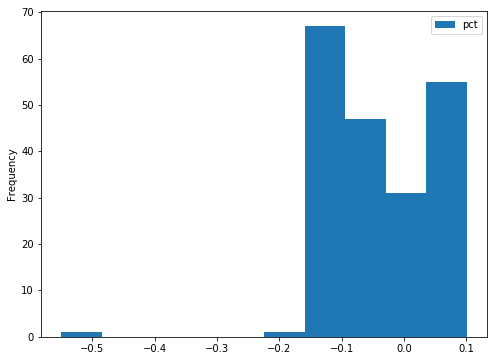

In [6]:
df.plot(y='pct',kind='hist',figsize=(8,6))

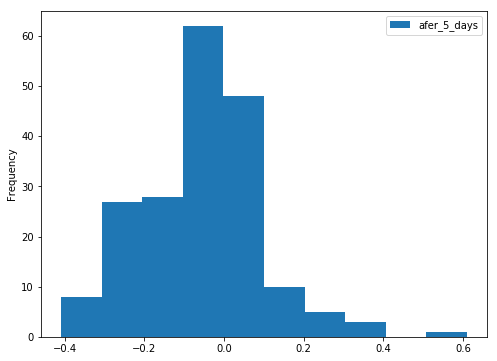

In [7]:
df.plot(y='afer_5_days',kind='hist',figsize=(8,6))

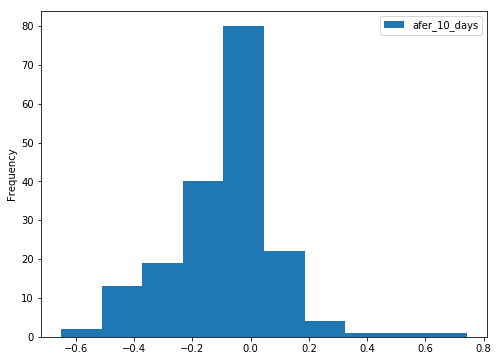

In [8]:
df.plot(y='afer_10_days',kind='hist',figsize=(8,6))